In [5]:
import gymnasium as gym
import gymnasium_2048 
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
from tqdm import tqdm
import pathlib
import os
import time
sys.path.append("..")

from simulations.base_agents import ConvDQNAgentWrapper, DQNAgentWrapper
from simulations.interpretable_agents import RandomAgent
from simulations.features import MetricsRecorder, feature_names
from simulations.run import run_episode

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ROOT = pathlib.Path.cwd()
ENV_ID = "gymnasium_2048/TwentyFortyEight-v0"

## Random Agent (simulation example)

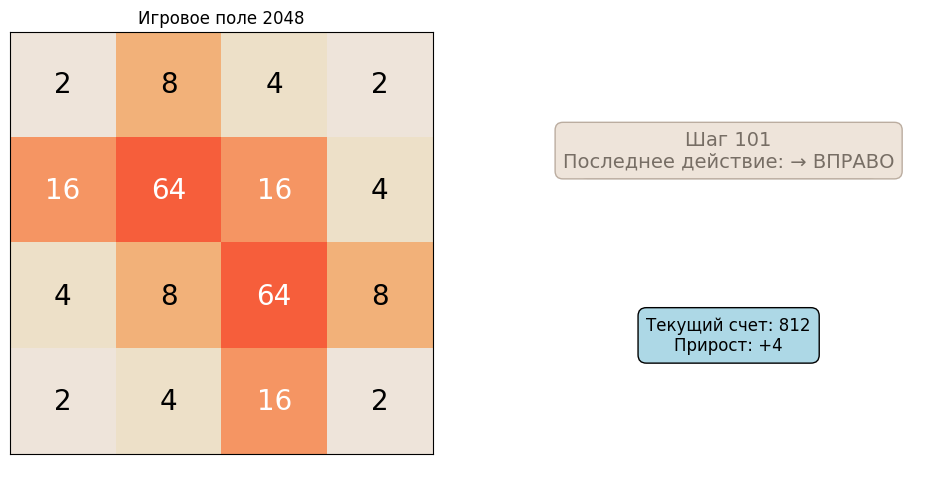


===== Финал =====
Игра завершена (ходов сыграно: 102)
Итоговый счёт: 812


812

In [4]:
env = gym.make(ENV_ID)
agent = RandomAgent(env) 
run_episode(env, agent, on_illegal="ask")

## DQN agent

In [ ]:
# https://github.com/YangRui2015/2048_env/tree/master 

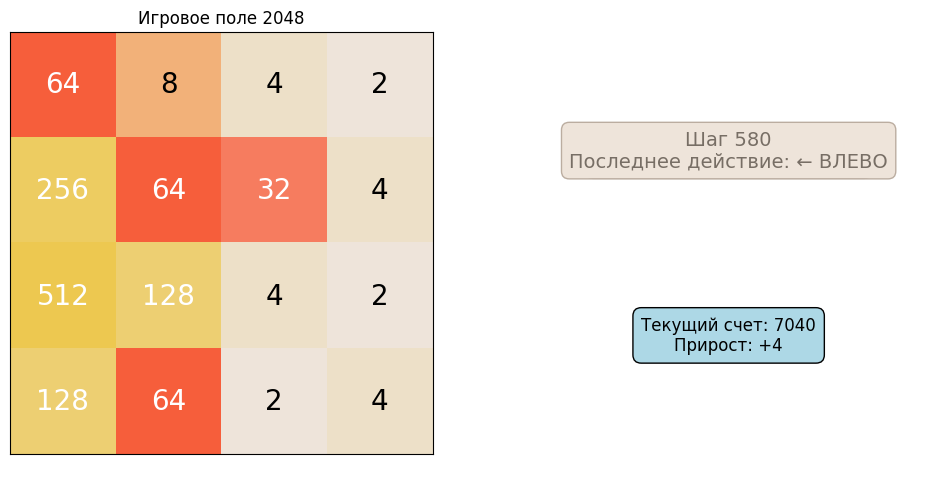


===== Финал =====
Игра завершена (ходов сыграно: 581)
Итоговый счёт: 7040


7040

In [7]:
env = gym.make(ENV_ID)
agent = DQNAgentWrapper(model_path="env_2048/save/best/dqn_7710.pkl")
run_episode(env, agent, on_illegal="ask")

## ConvDQN agent

In [ ]:
# https://github.com/IsacPasianotto/2048-DRL?ysclid=mamu0vry2y553024784 

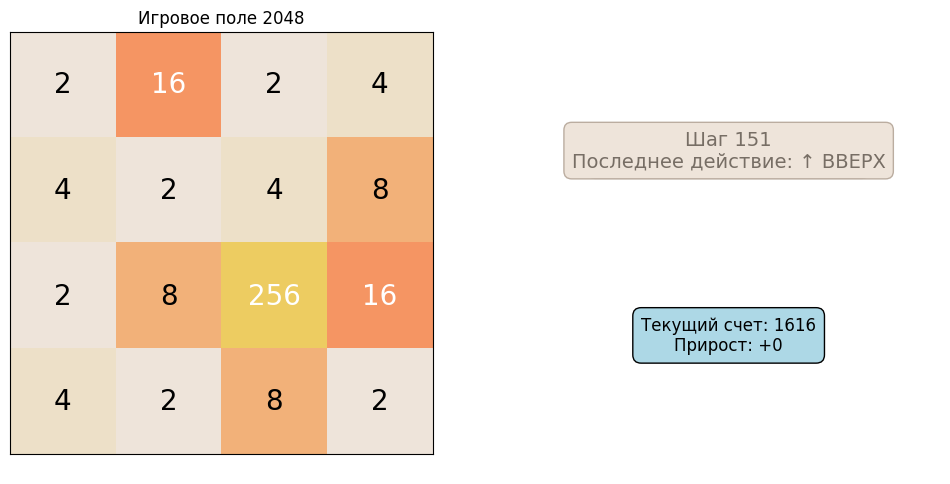


===== Финал =====
Игра завершена (ходов сыграно: 152)
Итоговый счёт: 1616


1616

In [8]:
env = gym.make(ENV_ID)
agent = ConvDQNAgentWrapper(model_path="drl2048/trained_architectures/convdqn_entropy_300_net.pt")
run_episode(env, agent, on_illegal="ask")

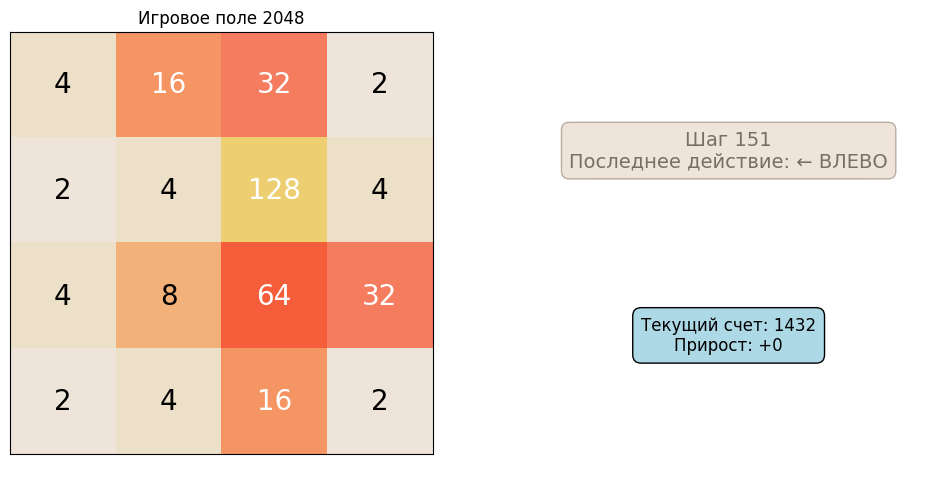


===== Финал =====
Игра завершена (ходов сыграно: 152)
Итоговый счёт: 1432


1432

In [9]:
env = gym.make(ENV_ID)
agent = ConvDQNAgentWrapper(model_path="drl2048/trained_architectures/convdqn_agent_long_train_net.pt")
run_episode(env, agent, on_illegal="ask")

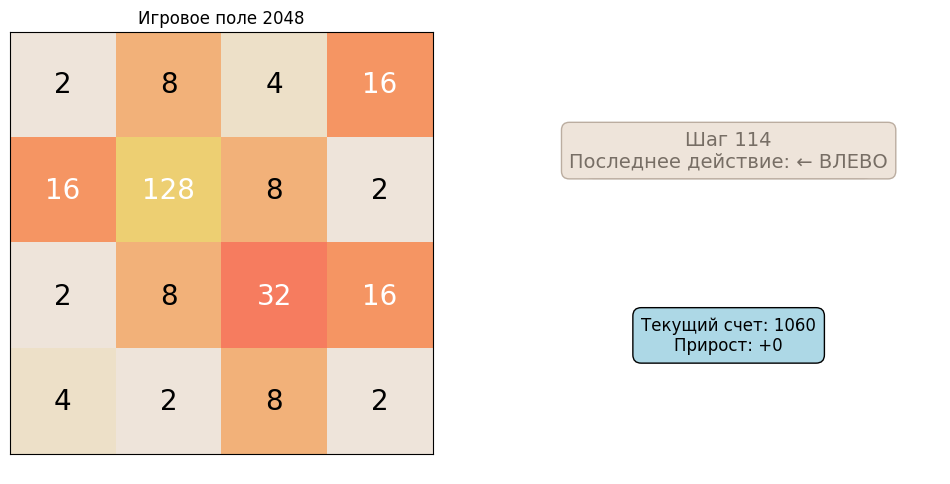


===== Финал =====
Игра завершена (ходов сыграно: 115)
Итоговый счёт: 1060


1060

In [12]:
env = gym.make(ENV_ID)
agent = ConvDQNAgentWrapper(model_path="drl2048/trained_architectures/convdqn_agent_lairobbins_300_net.pt")
run_episode(env, agent, on_illegal="ask")

## Symbolic regression

## Model explanation

In [ ]:
class _SparseLinearReward(nn.Module):
    def __init__(self, in_dim: int):
        super().__init__()
        # Инициализируем веса небольшими случайными значениями вместо нулей
        self.weight = nn.Parameter(torch.randn(in_dim) * 0.01)  # θ
        # Инициализируем логиты маски с небольшим положительным смещением
        self.mask_logits = nn.Parameter(torch.zeros(in_dim) + 0.1)  # логиты m

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        p = torch.sigmoid(self.mask_logits)  # (soft)
        m_hard = (p > 0.5).float()  # (hard)
        m = m_hard + (p - p.detach())  # STE: grad == grad(p)
        return (m * self.weight * x).sum(dim=1, keepdim=True)

    # ===== сервисные методы =====
    def hard_mask(self) -> np.ndarray:
        return (self.mask_logits.sigmoid()
                .detach().cpu().numpy() > 0.5).astype(int)

    def hard_weight(self) -> np.ndarray:
        return self.weight.detach().cpu().numpy() * self.hard_mask()


class Interpretable2048Agent(BaseAgent):
    """
    Агент, который может:
    • собрать датасет,
    • обучить разрежённые маски,
    • сохранять / загружать веса,
    • играть по интерпретируемой линейной политике.
    """

    # ------------------------ инициализация -------------------------------- #
    def __init__(self, env, weight_path: Optional[str] = None, device: str = "cpu"):
        super().__init__(env)
        self.device = torch.device(device)
        self._dim = len(feature_names)

        self.w_score: Optional[np.ndarray] = None
        self.w_pot: Optional[np.ndarray] = None
        if weight_path is not None:
            self.load_weights(weight_path)

    # ------------------------ публичное API -------------------------------- #
    def act(self, observation):
        assert self.w_score is not None, "call train() or load_weights() first"
        
        board = self._board_from_obs(observation)
        best_a, best_v = None, -np.inf
        
        # Сначала определим действительные ходы (которые меняют состояние)
        valid_actions = []
        for a in range(4):
            next_board, _, changed = self._apply_move(board, a)
            if changed:
                valid_actions.append(a)
        
        # Если есть действительные ходы, выбираем лучший из них
        if valid_actions:
            for a in valid_actions:
                next_board = self._simulate(board, a)
                φ = self._phi(next_board)
                v = (self.w_score @ φ) + 0.5 * (self.w_pot @ φ)
                if v > best_v:
                    best_v, best_a = v, a
        # Если нет действительных ходов, это конец игры, но выберем любое действие
        else:
            best_a = np.random.randint(0, 4)
        
        return best_a

    
    def train(
        self,
        episodes: int = 300_000,
        epsilon: float = 0.1,
        l1: float = 5e-4,  # Уменьшенный коэффициент l1
        ortho: float = 1e-3,  # Уменьшенный коэффициент ortho
        lr: float = 5e-3,  # Оптимизированная скорость обучения
        epochs: int = 20,  # Увеличенное число эпох
        batch_size: int = 512,
        save_path: str = "weights.npz",
        verbose: bool = True,
    ):
        if verbose:
            print(f"[collect] episodes={episodes} ε={epsilon}")
        
        dataset = self._collect(episodes, epsilon, verbose)
        
        if verbose:
            print(f"[learn] start optimisation with {len(dataset)} samples")
            # Анализ собранных данных
            r_score = np.array([d["r_score"] for d in dataset])
            r_pot = np.array([d["r_pot"] for d in dataset])
            print(f"Score rewards: mean={r_score.mean():.4f}, min={r_score.min():.4f}, max={r_score.max():.4f}")
            print(f"Potential rewards: mean={r_pot.mean():.4f}, min={r_pot.min():.4f}, max={r_pot.max():.4f}")
        
        weights = self._learn_masks(dataset, l1, ortho, lr, epochs, batch_size, self.device, verbose)
        
        # Проверка ненулевых весов
        nonzero_score = np.count_nonzero(weights["weight_score"])
        nonzero_pot = np.count_nonzero(weights["weight_potential"])
        
        if verbose:
            print(f"Non-zero weights: score={nonzero_score}/{len(weights['weight_score'])}, "
                f"potential={nonzero_pot}/{len(weights['weight_potential'])}")
            print(f"[save] → {save_path}")
        
        np.savez(save_path, **weights)
        self._set_internal_weights(weights)


    def save_weights(self, path="weights.npz"):
        assert self.w_score is not None
        np.savez(
            path,
            mask_score=(self.w_score != 0).astype(int),
            weight_score=self.w_score,
            mask_potential=(self.w_pot != 0).astype(int),
            weight_potential=self.w_pot,
        )

    def load_weights(self, path="weights.npz"):
        data = np.load(path)
        self.w_score = data["weight_score"]
        self.w_pot = data["weight_potential"]

    # -------------------- внутренние служебные методы --------------------- #
    @staticmethod
    def _board_from_obs(obs) -> np.ndarray:
        """observation -> 4×4 np.array со значениями 0,2,4,8, …"""
        return get_tile_value(obs)

    # ---------- util: dict-features -> np.array в фикс. порядке ------------ #
    @staticmethod
    def _dict_to_vec(feat_dict: Dict[str, Any]) -> np.ndarray:
        return np.array([feat_dict[name] for name in feature_names], dtype=np.float32)

    def _phi(self, board: np.ndarray) -> np.ndarray:
        d = extract_features(board)
        return d if isinstance(d, np.ndarray) else self._dict_to_vec(d)

    # ---------- симуляция хода (без env.unwrapped) ------------------------ #
    @staticmethod
    def _apply_move(board: np.ndarray, action: int):
        """
        Возвращает (new_board, reward, changed) без добавления случайной плитки.
        0=UP, 1=RIGHT, 2=DOWN, 3=LEFT
        """
        def _merge(line):
            buf, rew, skip = [], 0, False
            for i in range(len(line)):
                if line[i] == 0:
                    continue
                if (not skip) and i + 1 < len(line) and line[i] == line[i + 1]:
                    buf.append(line[i] * 2)
                    rew += line[i] * 2
                    skip = True
                else:
                    if skip:
                        skip = False
                        continue
                    buf.append(line[i])
            buf += [0] * (4 - len(buf))
            return buf, rew

        new = board.copy()
        total_reward = 0
        for idx in range(4):
            if action == 0:      # ↑
                merged, rew = _merge(list(board[:, idx]))
                new[:, idx] = merged
            elif action == 1:    # →
                merged, rew = _merge(list(board[idx, ::-1]))
                new[idx, ::-1] = merged
            elif action == 2:    # ↓
                merged, rew = _merge(list(board[::-1, idx]))
                new[::-1, idx] = merged
            else:                # ←
                merged, rew = _merge(list(board[idx, :]))
                new[idx, :] = merged
            total_reward += rew

        changed = not np.array_equal(board, new)
        return new, total_reward, changed

    def _simulate(self, board: np.ndarray, action: int) -> np.ndarray:
        next_board, _, changed = self._apply_move(board, action)
        return next_board if changed else board

    # ---------- сбор датасета -------------------------------------------- #
    def _collect(self, episodes: int, epsilon: float, verbose: bool):
        data: List[Dict[str, Any]] = []
        f_empty = "num_empty"
        iterator = trange(episodes, desc="Collect", disable=not verbose, ncols=85)
        
        for ep in iterator:
            obs, _ = self.env.reset()
            done = False
            
            while not done:
                cur_board = self._board_from_obs(obs)
                
                # Определяем легальные ходы (которые меняют состояние доски)
                legal = []
                for a in range(4):
                    _, _, changed = self._apply_move(cur_board, a)
                    if changed:
                        legal.append(a)
                
                # ε-жадный выбор из легальных ходов
                if legal and np.random.rand() >= epsilon:
                    action = np.random.choice(legal)
                else:
                    action = self.env.action_space.sample()
                
                obs, reward, terminated, truncated, _ = self.env.step(action)
                next_board = self._board_from_obs(obs)
                
                r_score = reward
                cur_dict = extract_features(cur_board)
                next_dict = extract_features(next_board)
                r_pot = next_dict[f_empty] - cur_dict[f_empty]
                
                data.append({"phi": self._phi(cur_board), "r_score": r_score, "r_pot": r_pot})
                
                done = terminated or truncated
        
        return data

    
    def _learn_masks(self, dataset, l1, ortho, lr, epochs, batch_size, device, verbose):
        M = self._dim
        models = {
            "score": _SparseLinearReward(M).to(device),
            "potential": _SparseLinearReward(M).to(device),
        }
        
        # Используем AdamW для лучшей регуляризации
        opt = optim.AdamW(
            list(models["score"].parameters()) + list(models["potential"].parameters()),
            lr=lr,
            weight_decay=1e-5
        )
        
        feats = torch.tensor(np.stack([d["phi"] for d in dataset]), device=device)
        r_score = torch.tensor(
            np.array([d["r_score"] for d in dataset]).reshape(-1, 1),
            device=device,
            dtype=torch.float32,
        )
        r_pot = torch.tensor(
            np.array([d["r_pot"] for d in dataset]).reshape(-1, 1),
            device=device,
            dtype=torch.float32,
        )
        
        # Нормализация данных - критически важна для стабильного обучения
        r_score_mean, r_score_std = r_score.mean(), r_score.std() + 1e-6
        r_pot_mean, r_pot_std = r_pot.mean(), r_pot.std() + 1e-6
        r_score_norm = (r_score - r_score_mean) / r_score_std
        r_pot_norm = (r_pot - r_pot_mean) / r_pot_std
        
        # Адаптивная регуляризация как в статье
        l1_schedule = lambda e: l1 * (1.0 - 0.7 * min(1.0, e / (epochs * 0.7)))
        ortho_schedule = lambda e: ortho * (1.0 - 0.7 * min(1.0, e / (epochs * 0.7)))
        
        n = feats.shape[0]
        idx = np.arange(n)
        
        for ep in trange(epochs, desc="Train", disable=not verbose, ncols=85):
            np.random.shuffle(idx)
            current_l1 = l1_schedule(ep)
            current_ortho = ortho_schedule(ep)
            
            for b in range(0, n, batch_size):
                j = torch.tensor(idx[b : b + batch_size], device=device)
                φ = feats[j]
                
                ŕ_score = models["score"](φ)
                ŕ_pot = models["potential"](φ)
                
                # Нормализация прогнозов
                ŕ_score_norm = (ŕ_score - r_score_mean) / r_score_std
                ŕ_pot_norm = (ŕ_pot - r_pot_mean) / r_pot_std
                
                # Улучшенная функция потерь с нормализованными данными
                loss_fid = nn.functional.mse_loss(ŕ_score_norm, r_score_norm[j]) + \
                        nn.functional.mse_loss(ŕ_pot_norm, r_pot_norm[j])
                
                # Штраф для предотвращения слишком маленьких весов
                weight_penalty = (torch.relu(0.01 - torch.abs(models["score"].weight)).sum() + 
                                torch.relu(0.01 - torch.abs(models["potential"].weight)).sum()) * 0.01
                
                # Компоненты разреженности и ортогональности
                spars = sum(m.mask_logits.sigmoid().sum() for m in models.values())
                overlap = (
                    models["score"].mask_logits.sigmoid() *
                    models["potential"].mask_logits.sigmoid()
                ).sum()
                
                loss = loss_fid + weight_penalty + current_l1 * spars + current_ortho * overlap
                
                opt.zero_grad()
                loss.backward()
                
                # Ограничение градиентов для стабильности
                torch.nn.utils.clip_grad_norm_(
                    list(models["score"].parameters()) + list(models["potential"].parameters()), 
                    1.0
                )
                
                opt.step()
                
            if verbose:
                print(f" epoch {ep + 1}/{epochs} loss={loss.item():.4g}")
                # Отладочная информация
                for name, model in models.items():
                    weight_nonzero = (model.weight.abs() > 1e-6).float().mean().item() * 100
                    mask_mean = model.mask_logits.sigmoid().mean().item()
                    print(f"   {name}: weight_nonzero={weight_nonzero:.1f}%, mask_mean={mask_mean:.4g}")
        
        return {
            "mask_score": models["score"].hard_mask(),
            "weight_score": models["score"].hard_weight(),
            "mask_potential": models["potential"].hard_mask(),
            "weight_potential": models["potential"].hard_weight(),
        }
        
    def analyze_learned_rules(self):
        """Анализирует правила, найденные агентом после обучения"""
        assert self.w_score is not None and self.w_pot is not None, "Веса не загружены или не обучены!"
        
        nonzero_score = np.count_nonzero(self.w_score)
        nonzero_pot = np.count_nonzero(self.w_pot)
        
        print(f"Статистика весов:")
        print(f"  Score weights: ненулевых={nonzero_score}/{self.w_score.size} "
            f"({nonzero_score/self.w_score.size*100:.1f}%)")
        print(f"  Potential weights: ненулевых={nonzero_pot}/{self.w_pot.size} "
            f"({nonzero_pot/self.w_pot.size*100:.1f}%)")
        
        print("\nТоп-5 признаков для score:")
        top_score_indices = np.argsort(-np.abs(self.w_score))[:5]
        for idx in top_score_indices:
            if self.w_score[idx] != 0:
                print(f"  {feature_names[idx]}: {self.w_score[idx]:.4f}")
        
        print("\nТоп-5 признаков для potential:")
        top_pot_indices = np.argsort(-np.abs(self.w_pot))[:5]
        for idx in top_pot_indices:
            if self.w_pot[idx] != 0:
                print(f"  {feature_names[idx]}: {self.w_pot[idx]:.4f}")
        
        # Визуализация интерпретируемых правил
        self._visualize_rules()
        
    def _visualize_rules(self):
        """Визуализирует важные правила в виде графика"""
        plt.figure(figsize=(12, 8))
        
        feature_indices = np.union1d(
            np.nonzero(self.w_score)[0],
            np.nonzero(self.w_pot)[0]
        )
        
        if len(feature_indices) > 0:
            selected_features = [feature_names[i] for i in feature_indices]
            score_weights = [self.w_score[i] for i in feature_indices]
            pot_weights = [self.w_pot[i] for i in feature_indices]
            
            x = np.arange(len(selected_features))
            width = 0.35
            
            plt.bar(x - width/2, score_weights, width, label='Score')
            plt.bar(x + width/2, pot_weights, width, label='Potential')
            
            plt.xlabel('Признаки')
            plt.ylabel('Веса')
            plt.title('Важные признаки и их веса')
            plt.xticks(x, selected_features, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.show()
        else:
            print("Нет ненулевых весов для визуализации")

    # ---------- служебное -------------------------------------------------- #
    def _set_internal_weights(self, w: Dict[str, np.ndarray]):
        self.w_score = w["weight_score"]
        self.w_pot = w["weight_potential"]

In [23]:
env = gym.make(ENV_ID)
agent = Interpretable2048Agent(env) 
agent.train(episodes=5_000)  

[collect] episodes=5000 ε=0.1


Collect:   0%|                                              | 0/5000 [00:00<?, ?it/s]c:\Users\Polina\Desktop\envs\project_2048\lib\site-packages\gymnasium_2048\envs\twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.total_score += self.step_score
Collect: 100%|███████████████████████████████████| 5000/5000 [29:21<00:00,  2.84it/s]


[learn] start optimisation with 600967 samples
Score rewards: mean=8.9753, min=0.0000, max=220.0000
Potential rewards: mean=-0.1165, min=-1.0000, max=5.0000


Train:   5%|██                                        | 1/20 [00:02<00:45,  2.40s/it]

 epoch 1/20 loss=774.7
   score: weight_nonzero=100.0%, mask_mean=0.4865
   potential: weight_nonzero=100.0%, mask_mean=0.4679


Train:  10%|████▏                                     | 2/20 [00:04<00:43,  2.40s/it]

 epoch 2/20 loss=2.87e+04
   score: weight_nonzero=100.0%, mask_mean=0.4843
   potential: weight_nonzero=100.0%, mask_mean=0.4484


Train:  15%|██████▎                                   | 3/20 [00:07<00:40,  2.40s/it]

 epoch 3/20 loss=1160
   score: weight_nonzero=100.0%, mask_mean=0.4843
   potential: weight_nonzero=100.0%, mask_mean=0.4478


Train:  20%|████████▍                                 | 4/20 [00:09<00:39,  2.44s/it]

 epoch 4/20 loss=5.611e+05
   score: weight_nonzero=100.0%, mask_mean=0.4503
   potential: weight_nonzero=100.0%, mask_mean=0.4235


Train:  25%|██████████▌                               | 5/20 [00:12<00:36,  2.44s/it]

 epoch 5/20 loss=8.32e+04
   score: weight_nonzero=100.0%, mask_mean=0.4503
   potential: weight_nonzero=100.0%, mask_mean=0.4231


Train:  30%|████████████▌                             | 6/20 [00:14<00:34,  2.44s/it]

 epoch 6/20 loss=2.96e+05
   score: weight_nonzero=100.0%, mask_mean=0.4503
   potential: weight_nonzero=100.0%, mask_mean=0.4223


Train:  35%|██████████████▋                           | 7/20 [00:16<00:31,  2.43s/it]

 epoch 7/20 loss=2.19e+05
   score: weight_nonzero=100.0%, mask_mean=0.4474
   potential: weight_nonzero=100.0%, mask_mean=0.4142


Train:  40%|████████████████▊                         | 8/20 [00:19<00:29,  2.42s/it]

 epoch 8/20 loss=2.214e+04
   score: weight_nonzero=100.0%, mask_mean=0.4474
   potential: weight_nonzero=100.0%, mask_mean=0.4138


Train:  45%|██████████████████▉                       | 9/20 [00:21<00:26,  2.42s/it]

 epoch 9/20 loss=5.895e+04
   score: weight_nonzero=100.0%, mask_mean=0.4474
   potential: weight_nonzero=100.0%, mask_mean=0.413


Train:  50%|████████████████████▌                    | 10/20 [00:24<00:24,  2.42s/it]

 epoch 10/20 loss=4.69e+05
   score: weight_nonzero=100.0%, mask_mean=0.4227
   potential: weight_nonzero=100.0%, mask_mean=0.3996


Train:  55%|██████████████████████▌                  | 11/20 [00:26<00:21,  2.42s/it]

 epoch 11/20 loss=9153
   score: weight_nonzero=100.0%, mask_mean=0.4227
   potential: weight_nonzero=100.0%, mask_mean=0.3996


Train:  60%|████████████████████████▌                | 12/20 [00:29<00:19,  2.42s/it]

 epoch 12/20 loss=3.176e+04
   score: weight_nonzero=100.0%, mask_mean=0.4227
   potential: weight_nonzero=100.0%, mask_mean=0.3995


Train:  65%|██████████████████████████▋              | 13/20 [00:31<00:16,  2.43s/it]

 epoch 13/20 loss=2.951e+05
   score: weight_nonzero=100.0%, mask_mean=0.4226
   potential: weight_nonzero=100.0%, mask_mean=0.3992


Train:  70%|████████████████████████████▋            | 14/20 [00:33<00:14,  2.42s/it]

 epoch 14/20 loss=5406
   score: weight_nonzero=100.0%, mask_mean=0.4225
   potential: weight_nonzero=100.0%, mask_mean=0.3988


Train:  75%|██████████████████████████████▊          | 15/20 [00:36<00:12,  2.44s/it]

 epoch 15/20 loss=9.891e+04
   score: weight_nonzero=100.0%, mask_mean=0.4169
   potential: weight_nonzero=100.0%, mask_mean=0.4132


Train:  80%|████████████████████████████████▊        | 16/20 [00:38<00:09,  2.42s/it]

 epoch 16/20 loss=1.531e+05
   score: weight_nonzero=100.0%, mask_mean=0.3961
   potential: weight_nonzero=100.0%, mask_mean=0.3964


Train:  85%|██████████████████████████████████▊      | 17/20 [00:41<00:07,  2.41s/it]

 epoch 17/20 loss=2.4e+04
   score: weight_nonzero=100.0%, mask_mean=0.3869
   potential: weight_nonzero=100.0%, mask_mean=0.4047


Train:  90%|████████████████████████████████████▉    | 18/20 [00:43<00:04,  2.40s/it]

 epoch 18/20 loss=6.785e+05
   score: weight_nonzero=100.0%, mask_mean=0.3546
   potential: weight_nonzero=100.0%, mask_mean=0.3799


Train:  95%|██████████████████████████████████████▉  | 19/20 [00:45<00:02,  2.41s/it]

 epoch 19/20 loss=1.734e+05
   score: weight_nonzero=100.0%, mask_mean=0.2775
   potential: weight_nonzero=100.0%, mask_mean=0.3456


Train: 100%|█████████████████████████████████████████| 20/20 [00:48<00:00,  2.42s/it]

 epoch 20/20 loss=1.308e+05
   score: weight_nonzero=100.0%, mask_mean=0.2775
   potential: weight_nonzero=100.0%, mask_mean=0.3454
Non-zero weights: score=4/24, potential=3/24
[save] → weights.npz


In [24]:
print(agent.w_score)
print(agent.w_pot)

[-0.         -0.          0.22406639 -0.         -0.         -0.
  0.69365805 -0.         -0.         -0.          0.63530558  0.
 -0.         -0.         -0.         -0.         -0.         -0.
 -0.         -1.06365788  0.         -0.         -0.          0.        ]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.68914063e-04  0.00000000e+00 -2.62095360e-03
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  4.31776226e-01]


Статистика весов:
  Score weights: ненулевых=4/24 (16.7%)
  Potential weights: ненулевых=3/24 (12.5%)

Топ-5 признаков для score:
  conv_horiz_gradient: -1.0637
  max_tile_ratio: 0.6937
  potential_merges: 0.6353
  num_empty: 0.2241

Топ-5 признаков для potential:
  conv_3_in_col_same_tiles: 0.4318
  entropy: -0.0026
  snake_weighted_sum: -0.0002


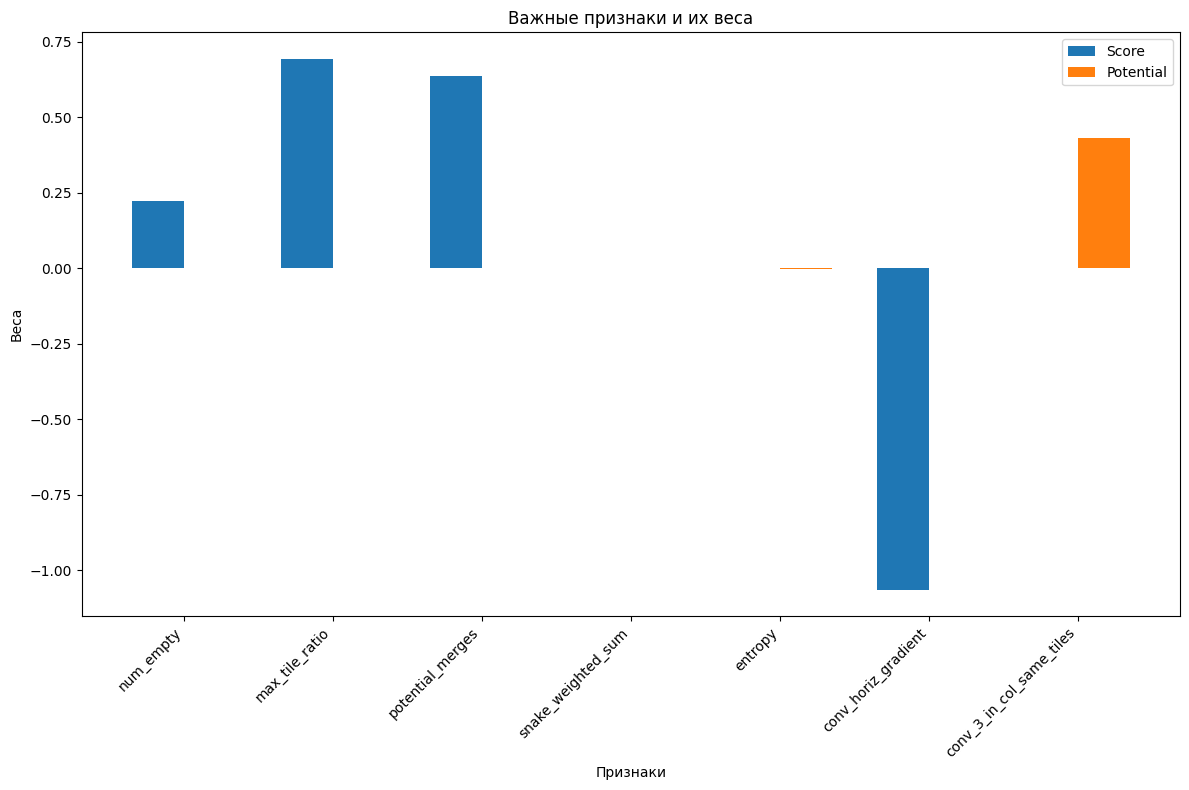

In [25]:
agent.analyze_learned_rules()

In [ ]:
env = gym.make(ENV_ID)

_ = run_simulation(
    env,
    agent, 
    delay=0.25,               
    visualize=True,         
)   

env_params={'oracle_path': 'weights.npz'}

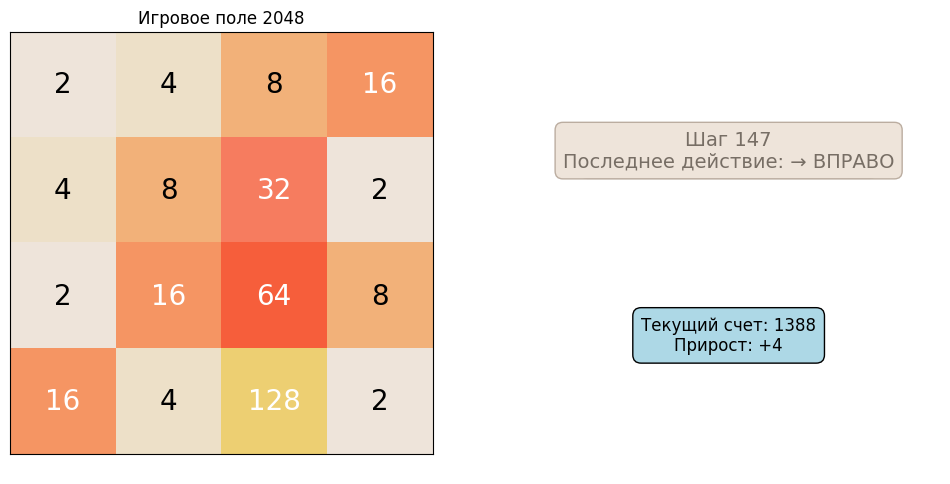


===== Финал =====
Игра завершена (ходов сыграно: 148 )
Итоговый счёт: 1388


In [ ]:
env = gym.make(ENV_ID)

_ = run_episode(
    env,
    agent, 
    delay=0.25,               
    visualize=True,         
)   

## DTPO agent

In [ ]:
class SafeScore2048(gym.Wrapper):
    """Делает счёт Python-int, чтобы избежать переполнения."""
    def __init__(self, env):
        super().__init__(env)
        self.total_score = 0          # Python int без ограничения

    def step(self, action):
        obs, reward, term, trunc, info = self.env.step(action)
        # Преобразуем к int  /  float  (на выбор)
        reward = int(reward)          # или float(reward)
        self.total_score += reward
        # Обновим info, чтобы не потерять статистику
        info["score"]       = self.total_score
        info["step_score"]  = reward
        return obs, reward, term, trunc, info

def make_safe_env(env_id):
    base = gym.make(env_id)
    return SafeScore2048(base)

In [ ]:
TRAIN_EPISODES = 1000     # raise for better play (2‑3 k typical)
BATCH_SIZE = 10_000   # on‑policy steps per DTPO iteration
EVAL_EVERY = 25       # eval & log
SAVE_DIR = ROOT / "dtpo_models"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
env = make_safe_env(ENV_ID) # gym.make(ENV_ID)
agent = DTPOAgent(
    env = env,
    batch_size = BATCH_SIZE,
    max_leaf_nodes= 128,   # deeper tree → more expressive policy
)

print(f'Features per state: {len(feature_names)} – action space: {agent.action_size}')

Features per state: 24 – action space: 4


In [ ]:
returns_hist   = []
max_tile_hist  = []
metrics = MetricsRecorder(save_dir=str(SAVE_DIR / 'metrics'))

for ep in tqdm(range(1, TRAIN_EPISODES + 1), desc='Episode'):
    # 1. collect on‑policy batch (DTPO iteration)
    batch = agent.collect_batch()
    S, A, R, S_next, D = batch['states'], batch['actions'], batch['rewards'], batch['next_states'], batch['dones']

    # 2. estimate values & advantages
    with torch.no_grad():
        v_s      = agent.value_net(torch.FloatTensor(S).to(device)).cpu().numpy().squeeze()
        v_next   = agent.value_net(torch.FloatTensor(S_next).to(device)).cpu().numpy().squeeze()
    advs = agent.compute_gae(R, v_s, v_next, D)

    # 3. update policy + value
    agent.update_policy(S, A, advs)
    agent.update_value_function(S, R, S_next, D)

    # --- quick evaluation (1 episode) ----
    if ep % EVAL_EVERY == 0:
        eval_env = gym.make(ENV_ID, render_mode=None)
        obs, _ = eval_env.reset()
        done, score, board_max, steps = False, 0, 0, 0
        while not done:
            act = agent.act(obs)
            obs, rew, term, trunc, _ = eval_env.step(act)
            done = term or trunc
            score += rew
            board_max = max(board_max, np.max(dtpo_agent.get_tile_value(obs)))
            steps += 1
        returns_hist.append(score); max_tile_hist.append(board_max)
        metrics.record(score, board_max, steps)
        print(f'Ep {ep:>4}: score {score:>6.0f}  |  max‑tile {board_max}  |  steps {steps}')
        if score >= max(returns_hist):
            agent.save(SAVE_DIR / 'best_dtpo')  # keep best

Episode:   0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\Polina\Desktop\envs\project_2048\lib\site-packages\gymnasium_2048\envs\twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.total_score += self.step_score
c:\Users\Polina\Desktop\envs\project_2048\lib\site-packages\gymnasium_2048\envs\twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.total_score += self.step_score
c:\Users\Polina\Desktop\envs\project_2048\lib\site-packages\gymnasium_2048\envs\twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.total_score += self.step_score
c:\Users\Polina\Desktop\envs\project_2048\lib\site-packages\gymnasium_2048\envs\twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.total_score += self.step_score
c:\Users\Polina\Desktop\envs\project_2048\lib\site-packages\gymnasium_2048\envs\twenty_forty_eight.py:250: RuntimeWarning: overflow encountered in scalar add
  self.to

KeyboardInterrupt: 